In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image, ImageDraw
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

In [3]:
from src.datagens import WSIDatagen
from src.datagens import DataSource
from src.config import SLIDE_DIR
from src.datagens import Augmenter

In [4]:
import json
with (Path('.').resolve().parent / 'configs' / 'level1.json').open('r') as json_in:
    params = json.load(json_in)

In [5]:
params['data']['meta']['level'] = 1
params['data']['meta']['context_size'] = 3
params['data']['meta']['tile_size'] = 512
params['data']['dataset'] = '/mnt/data/crc_ml/data/processed/Prostata/level1/r512px/c256px/t512px/no_overlap/datasets/1602530237.h5'
params['model']['input_shape'] = (512,512)
params['seed'] = 2020

In [6]:
# CREATE DATASOURCE
ds = DataSource()
ds.add_dataset(params['data']['dataset'], 'train')
train_ds, valid_ds = ds.split(0.03)

test_ds = DataSource()
test_ds.add_dataset(params['data']['dataset'], 'test')

In [7]:
test_ds.coord_maps = [x for x in test_ds.coord_maps if x.stem == 'TP-2019_2623-12-1']

In [8]:
# CREATE DATAGEN
datagen = WSIDatagen(params, slide_dir=SLIDE_DIR)

In [9]:
# GET GENERATORS
train_gen, valid_gen = datagen.get_training_generator(train_ds, valid_ds, True, True)
#test_gen = datagen.get_sequential_generator((96,96), test_ds)

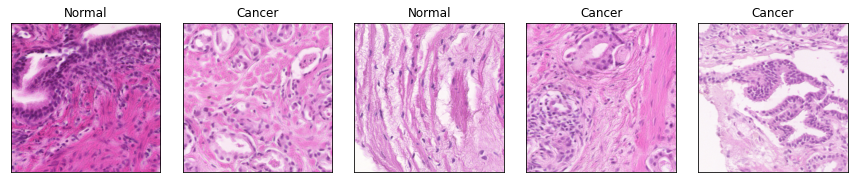

In [18]:
def label_name(lab_id):
    return 'Cancer' if int(lab_id) == 1 else 'Normal'

def showcase_augmentation(generator, num_samples, num_augments_per_sample, step):
    num_cols = num_samples
    num_rows = (1 + num_augments_per_sample)
    num_display_imgs = num_rows * num_cols
    
    fig = plt.figure(figsize=(num_cols*3, 2*num_rows+2))
    fig.suptitle('MOU WSI Augmentation Samples (prostate)', fontsize=32)

    generator.tile_extractor.use_augment = False
    imgs, labels = generator[step]
    for idx, (img, lab) in enumerate(zip(imgs, labels), 1):
        img = img[4]
        ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
        if not isinstance(img, Image.Image):
            img = Image.fromarray(((img + 1)*127.5).astype(np.uint8))
        plt.imshow(img)
        ax.set_title(label_name(lab))
        if idx % num_cols == 0:
            break
        
    generator.tile_extractor.use_augment = True
    for _ in range(num_augments_per_sample):
        imgs, labels = generator[step]
        for idx, (img, lab) in enumerate(zip(imgs, labels), idx+1):
            img = img[4]
            ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
            if not isinstance(img, Image.Image):
                img = Image.fromarray(((img + 1)*127.5).astype(np.uint8))
            plt.imshow(img)
            if idx % num_cols == 0:
                break

def display_tile(generator, step):
    num_cols = 5
    num_rows = 1
    num_display_imgs = num_rows * num_cols
    
    fig = plt.figure(figsize=(num_cols*3, 3*num_rows))
    #fig.suptitle('MOU WSI Unaugmented Macrotile (prostate)', fontsize=32)
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    generator.tile_extractor.use_augment = False
    for idx in range(1, num_display_imgs+1):
        img, lab = generator[step+idx]
        img = img[0][4]
        ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
        if not isinstance(img, Image.Image):
            img = Image.fromarray(((img + 1)*127.5).astype(np.uint8))
        ax.set_title(label_name(lab))
        plt.imshow(img)
        
    '''fig = plt.figure(figsize=(num_cols*3, 3*num_rows))
    #fig.suptitle('MOU WSI Augmented Macrotile (prostate)', fontsize=32)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    generator.tile_extractor.use_augment = True
    for idx in range(1, num_display_imgs+1):
        img, lab = generator[step+idx]
        img = img[0][4]
        ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
        if not isinstance(img, Image.Image):
            img = Image.fromarray(((img + 1)*127.5).astype(np.uint8))
        plt.imshow(img) '''
                
def display_macrotile(generator, step):
    num_cols = 3
    num_rows = 3
    num_display_imgs = num_rows * num_cols
    
    fig = plt.figure(figsize=(num_cols*5, 1*num_rows))
    #fig.suptitle('MOU WSI Unaugmented Macrotile (prostate)', fontsize=32)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    generator.tile_extractor.use_augment = False
    img, lab = generator[step]
    img = img[0]
    for idx, sub_img in enumerate(img, 1):
        ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
        if not isinstance(sub_img, Image.Image):
            sub_img = Image.fromarray(((sub_img + 1)*127.5).astype(np.uint8))
        plt.imshow(sub_img)
        
    fig = plt.figure(figsize=(num_cols*5, 1*num_rows))
    #fig.suptitle('MOU WSI Augmented Macrotile (prostate)', fontsize=32)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    generator.tile_extractor.use_augment = True
    img, lab = generator[step]
    img = img[0]
    for idx, sub_img in enumerate(img, 1):
        ax = fig.add_subplot(num_rows, num_cols, idx, xticks=[], yticks=[])
        if not isinstance(sub_img, Image.Image):
            sub_img = Image.fromarray(((sub_img + 1)*127.5).astype(np.uint8))
        plt.imshow(sub_img)
        
display_tile(train_gen, 15)

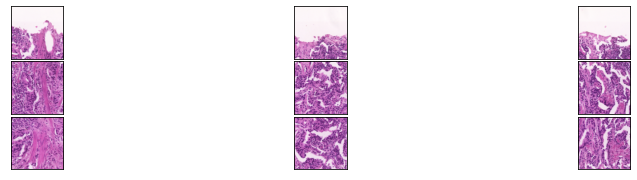

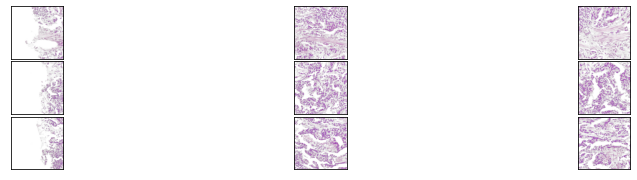

In [11]:
display_macrotile(train_gen, 125)

In [ ]:
X,_ = train_gen.unaugmented(0)